## Test project
* Requirements
    * Stocks folder [Huge Stock Market Dataset (BORIS MARJANOVIC, Kaggle)](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)

Note: All code has been generated using ChatGPT.

Idea
* Load data
* Create event variables for larger dips
* Run a machine learning algorithm on these data

Let us start by loading data for one stock. Let us also plot the value of the stock for the entire time period to confirm that the data were loaded correctly.

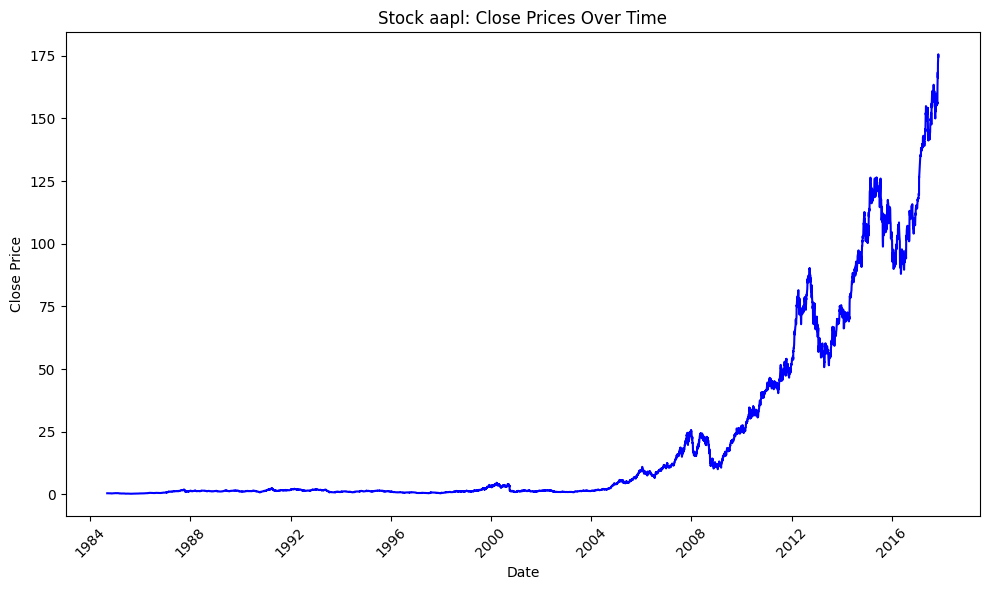

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def give_stock_data(stock="aapl"):
    # Define the file path for Apple stock data
    individual_stock_file = 'Data/Archive/Stocks/' + stock + '.us.txt'  # Update the file path based on the file's location

    # Load the data into a pandas DataFrame
    individual_stock_data = pd.read_csv(individual_stock_file)

    # Convert the 'Date' column to a datetime object
    individual_stock_data['Date'] = pd.to_datetime(individual_stock_data['Date'])
    return individual_stock_data

def plot_stock_price(stock_data, stock_name="aapl"):
    # Plotting the Close prices over time
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], color='blue')
    plt.title('Stock ' + stock_name + ': Close Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

dat = give_stock_data(stock="aapl")
plot_stock_price(dat, stock_name="aapl")


It appears that the data have been loaded successfully.

Next, let us create the function which will generate the event variable.

In [5]:
def give_event_data(stock_data, event_threshold=-1): 
    # Calculate daily percentage change in Close price
    stock_data['Daily_Return'] = stock_data['Close'].pct_change() * 100

    # Set threshold values for events
    threshold = event_threshold  

    # Create 'event' for a dip larger than argument threshold 
    stock_data['event'] = stock_data['Daily_Return'] <= threshold

    # Display the modified DataFrame
    stock_data.head()

    return stock_data


Above we have created the variable `event`. Variable corresponds to a decrease in the stock's value in one day which magnitude is of the same size as threshold specified as function argument.

In [7]:
def calculate_event_frequency(stock_data, threshold): 
    # Calculate frequency of event1 (1% dip) and event2 (10% dip)
    event_count = stock_data['event'].sum()
    #event2_count = apple_stock_data['event2'].sum()

    # Total number of data points
    total_data_points = len(stock_data)

    # Calculate frequencies
    event_frequency = event_count / total_data_points
    #event2_frequency = event2_count / total_data_points
    dip_size = str(-threshold)
    #print(f"Frequency of " + dip_size + "% dip (event1): {event1_frequency * 100:.2f}%")
    print(f"Frequency of {dip_size}% dip (event): {event_frequency * 100:.2f}%")



threshold = -1  # 1% dip
#threshold = -10  # 10% dip

dat = give_event_data(dat, event_threshold=threshold)
calculate_event_frequency(dat, threshold)


Frequency of 1% dip (event): 29.73%


Next, let us try to train a machine learning algorithm to predict when these events take place. Let us first try to predict the $1\%$ dips.

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def train_first_model(stock_data, n_splits = 15, n_estimators=100):

    # Features (X) and Target variable (y)
    # Considering 'Open', 'High', 'Low', 'Close', 'Volume' as features for simplicity
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    X = stock_data[features]
    y = stock_data['event']  # Change to 'event2' for 10% dip

    # Define the number of splits for time series cross-validation
    #n_splits = 15 # You can adjust this value

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize Random Forest model
    forest_model = RandomForestClassifier(n_estimators=n_estimators)  # You can adjust parameters

    # Perform time series cross-validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        forest_model.fit(X_train, y_train)
        y_pred = forest_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_rep)

train_first_model(dat, n_splits = 15, n_estimators=100)


Accuracy: 0.6743
Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.99      0.80       349
        True       0.71      0.03      0.06       173

    accuracy                           0.67       522
   macro avg       0.69      0.51      0.43       522
weighted avg       0.69      0.67      0.56       522

Accuracy: 0.7797
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.87      0.85       364
        True       0.65      0.58      0.62       158

    accuracy                           0.78       522
   macro avg       0.74      0.72      0.73       522
weighted avg       0.77      0.78      0.78       522

Accuracy: 0.7261
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.81      0.80       351
        True       0.59      0.56      0.57       171

    accuracy                           0.73       522
   macro